In [1]:
%matplotlib widget
from helper import *

<h1>Dual Quaternion Differential Kinematics</h1>

Differential Kinematics (DK) is an essential concept in robotics and automation, dealing with the relationship between the joint velocity of the cobot and its end effector or tool. This relationship is essential for controlling the motion of the cobot, particularly in tasks that require path tracking in cartesian space. 

To derive the differential kinematics, first, the cobot's forward kinematics have to be defined; this is done using the example of MAiRA from Neura Robotics GmbH. These forward kinematics are then used to compute the matrix entries of the Jacobian matrix $J$ which plays a pivotal role in the differential kinematics. The Jacobian matrix provides a linear mapping between the joint velocities and end-effector velocities in the robot's workspace, which is inversely used in practice to find the desired joint positions and velocities given a desired trajectory in cartesian space.

The study of differential kinematics not only facilitates the understanding of the velocity kinematics of the robot's motion, but also gives insights into the analysis of kinematic singularities and dexterity. Kinematic singularities are configurations of the cobot where the jacobian loses rank, and specific end-effector velocities become infeasible, which is critical for path planning and execution. 

Contrary to many classical approaches, the differential kinematics will be defined in the dual quaternion space $\mathbb{H}$ to leverage the benefits of dual quaternion algebra and the lack of representative singularities.

In the context of this thesis, the differential kinematics play an important role as they are used in the newly developed advanced control method, which involves predictive control.

<h2>Screw Theoretic Forward Kinematics</h2>

The fact that a screw transformation rotates any frame multiplied with the respective Lie-theoretic exponential map around the screw axis can be leveraged to construct the forward kinematics of a cobot. 
As presented by <cite id="7hdpn"><a href="#zotero%7C16222978%2FUIFPWU6T">(Lynch &#38; Park, 2017)</a></cite> for the case of matrix exponentials, for the forward kinematics, each joint is represented by a screw axis These screw axes are defined by its orientation and position in space. These parameters are relative to the base coordinate system in a defined and constant home position $\underline{M}$. The homeposition and the position and orientation of the screw axis on the example of maira can be seen in [Figure 3.1](#figure31).

<a id="figure31"></a>

<img src="./Resources/maira_screw_axis.png" alt="calibration scheme" style="max-width: 600px; width: 100%; display: block; margin-left: auto; margin-right: auto;margin-top: 10px;">

<p style="text-align:center"><strong>Figure 3.1</strong>: Maira7M from Neura Robotics. </p>

The home position is typically defined as the spatial transformation returned by the forward kinematics if all joint angles are set to zero, but can be chosen freely in practice. The corresponding positions and orientations of the screws, as defined in the base frame of the robot, can be found in [Table 3.1](#table31).

<a id="table31"></a>

<table>
    <thead>
      <tr>
        <th>Link</th>
        <th>rotation axis</th>
        <th>screw position</th>
      </tr>
    </thead>
    <tbody>
      <tr>
        <td>1</td>
        <td>$(0,0,1)$</td>
        <td>$(0,0,0)$</td>
      </tr>
      <tr>
        <td>2</td>
        <td>$(0,1,0)$</td>
        <td>$(0,0,0.438)$</td>
      </tr>
      <tr>
        <td>3</td>
        <td>$(0,0,1)$</td>
        <td>$(0,0,0.438)$</td>
      </tr>
      <tr>
        <td>4</td>
        <td>$(0,1,0)$</td>
        <td>$(0,0,1.138)$</td>
      </tr>
      <tr>
        <td>5</td>
        <td>$(0,0,1)$</td>
        <td>$(0,0,1.138)$</td>
      </tr>
      <tr>
        <td>6</td>
        <td>$(0,1,0)$</td>
        <td>$(0,0,1.838)$</td>
      </tr>
      <tr>
        <td>7</td>
        <td>$(0,0,1)$</td>
        <td>$(0,0,1.838)$</td>
      </tr>
    </tbody>
</table>

<p style="text-align:center"><strong>Table 3.1</strong>: Screw parameters for Maira7M from Neura Robotics.</p>

with the screws $\bar{\underline{s}}_i$ constructed from the table and the joint angles $\theta_i$ the unit dual quaternionic screw transformations can be defined: 

$$
\underline{\xi}_i = e^{\frac{\theta_i}{2}\bar{\underline{s}}_i} 
$$

With these transformations the transformation between the baseframe and TCP can be defined:

$$ 
{}_0\underline{\xi}^{TCP} = (\Pi_{i = 0}^{n = 7} \underline{\xi}_i) \underline{M}
$$

The pre defined homeposition $\underline{M}$ is the frame, that is being manipulated and transformed into the final pose by the screws. It is successively rotated around each screw and represents the TCP transformation ${}_0\underline{\xi}^{TCP}$ from base to end effector. For this example we choose the flange position of Maira, but any transformation could be given. The following code example shows how to set up the screw theory forward kinematics for MAiRA in code.

In [2]:
s1 = DualQuaternion.screwAxis(0,0,1, 0,0,0)
s2 = DualQuaternion.screwAxis(0,1,0, 0,0,0.438)
s3 = DualQuaternion.screwAxis(0,0,1, 0,0,0.438)
s4 = DualQuaternion.screwAxis(0,1,0, 0,0,1.138)
s5 = DualQuaternion.screwAxis(0,0,1, 0,0,1.138)
s6 = DualQuaternion.screwAxis(0,1,0, 0,0,1.838)
s7 = DualQuaternion.screwAxis(0,0,1, 0,0,1.838)

screws = [s1, s2, s3, s4, s5, s6, s7]

M_flange = DualQuaternion.fromQuatPos(Quaternion(1,0,0,0), [0,0,1.953])

def forward_kinematics(theta, screws_0, M):
    x = DualQuaternion.basicConstructor(1,0,0,0, 0,0,0,0)
    for i in range(len(theta)):
        x = x*DualQuaternion.exp(0.5*theta[i]*screws_0[i])
    
    return x*M

theta_example = [0, 0.2, 0.0, 1.56, -0.4, 1.6, 2]

x_0_TCP = forward_kinematics(theta_example, screws, M_flange)
print(x_0_TCP)

DualQuaternion(Real: Quaternion(0.109, 0.811, 0.540, -0.197), Dual: Quaternion(-0.226, -0.192, 0.437, 0.283))


<h2>The Jacobian</h2>

Screw Theory allows for an efficient and elegant way to compute the Jacobian matrix $J$ when compared to classical methods. Here, often numerical algorithms like shown in <cite id="5y8oq"><a href="#zotero%7C16222978%2F3S984H2Z">(Yazdanpanah Abdolmalaki, 2017)</a></cite> are chosen, which involve the extraction of the rotation axes from the robots kinematic model, defining the rotational part of $J$ and a cross product computation for the translational part. In screw theory, the columns of $J$ are transformed screws. In <cite id="c1wxs"><a href="#zotero%7C16222978%2FUIFPWU6T">(Lynch &#38; Park, 2017)</a></cite> general forward and velocity kinematics are differentiated into either <i>Body</i> or <i>Space</i> representation, the representation chosen to be shown in this thesis is the space representation. It differs mathematically from the geometric Jacobian often used classical approaches but can be applied in the same way practically, if the space representation is chosen coherently for the velocity computations in the case of differential kinematics or the error computation in the case of inverse kinematics.

To find the space Jacobian $J_s$, the line transformation operation and the exponential mapping of unit dual quaternions are needed. The computation can be found in the following code block.


In [3]:
def getSpaceJacobian(theta, screws_0):
    
    # initialize transformation as identity transformation
    x = DualQuaternion.basicConstructor(1,0,0,0, 0,0,0,0)
    
    # initialize jacobian with zeros
    J = np.zeros((8, len(theta)))
    
    # loop over all joints
    for i in range(len(theta)):
        
        # get screw (defined in base frame) from list
        s_0 = screws_0[i]
        
        #transform screw with the line transformation
        s_i = x*s_0*x.inverse()
        
        # progress transformation with screw and joint angle
        x = x*DualQuaternion.exp(0.5*theta[i]*s_0)
        
        # assign transformed screw to Jacobian row
        J[:, i] = s_i.asVector().flatten()
    
    return J

J = getSpaceJacobian(theta_example, screws)
print(J)

[[   0.000    0.000    0.000    0.000    0.000   -0.000    0.000]
 [   0.000    0.000    0.199    0.000    0.982   -0.073   -0.202]
 [   0.000    1.000    0.000    1.000    0.000    0.921   -0.389]
 [   1.000    0.000    0.980    0.000   -0.188   -0.382   -0.899]
 [   0.000    0.000    0.000    0.000    0.000    0.000    0.000]
 [   0.000   -0.438    0.000   -1.124    0.000   -0.914    0.386]
 [   0.000    0.000    0.087    0.000    1.130    0.243    0.543]
 [   0.000    0.000    0.000    0.139    0.000    0.761   -0.322]]


Note that the Jacobian from this algorithm has the dimensionality of $J \in \mathbb{R}^{8 \times DoF}$, which is caused by the dual quaternion dimensionionality of eight. Whether the matrix should be $6 \times DoF$ or $8 \times DoF$ can be chosen depending on the use case. If the classic form factor is needed, excluding the first and fifth row will result in $J \in \mathbb{R}^{6 \times DoF}$. This can be easily achieved by the vectorization $[{}_i\bar{\underline{s}}_i]_{6vec}$, intruduced in <a href="./3.1_spatial_transformations_with_dual_quaternions.ipynb">Chapter 3.1</a>. Besides the space representation, the body Jacobian is frequenty used throughout this thesis, the implementation is omitted here and can be found in the <a href="./Simulation/ForwardKinematics.py">ForwardKinematics.py</a> file.

Besides the elegant and efficient computation, another benefit of the screw theoretic contemplation is that higher derivatives of $J$ are very easy and efficiently computeable when compared to classical approaches like the one found in <cite id="tbcfd"><a href="#zotero%7C16222978%2F63SGHUSV">(Angeles, 2014)</a></cite>. An example for the first Jacobian derivative $\dot{J}$ can be seen in the next code block. Note that the algebraic property of the exponential function is leveraged to compute the screw transformation derivative, which is needed to find the derivative of the screw axis w.r.t time.
 
$$
\frac{d}{dt} \left(e^{\frac{\theta_i}{2}\underline{\bar{s}}_i}\right) =  e^{\frac{\theta_i}{2}\underline{\bar{s}}_i} \otimes \frac{\dot{\theta}_i}{2}\underline{\bar{s}}_i
$$

The resulting algorithm can be easily extended to further derivatives by application of the chain rule of differentiation. A unique feature of the screw theory approach!

In [4]:
def getSpaceJacobian_dot(theta, theta_dot, screws_0):
    
    # initialize transformation as identity transformation
    x = DualQuaternion.basicConstructor(1,0,0,0, 0,0,0,0)
    
    # initialialize transformation derivative as zero
    x_dot = DualQuaternion.basicConstructor(0,0,0,0, 0,0,0,0)
    
    # initialize Jacobian derivative with zeros
    J_dot = np.zeros((8, len(theta)))
    
    # loop over all joints
    for i in range(len(theta)):
        # get screw (defined in base frame) from list
        s_0 = screws_0[i]
        
        #compute screw derivative and transform
        s_i_dot = x_dot*s_0*x.inverse() + x*s_0*x_dot.inverse()
        
        # compute temporary transformation via exponential map
        x_temp = DualQuaternion.exp(0.5*theta[i]*s_0)
        
        # compute temporary transformation derivative via exponential derivative
        x_dot_temp = DualQuaternion.exp(0.5*theta[i]*s_0)*(0.5*theta_dot[i]*s_0)
        
        # update transformation derivative
        x_dot = x_dot*x_temp + x*x_dot_temp
        
        # update transformation
        x = x*x_temp
        
        #assign screw derivative to jacobian derivative row
        J_dot[:, i] = s_i_dot.asVector().flatten()
    
    return J_dot

theta_dot = np.array([1, 1, 1, 2, 2, 2, 3])

print(getSpaceJacobian_dot(theta_example, theta_dot, screws))

[[   0.000    0.000    0.000    0.000    0.000    0.000    0.000]
 [   0.000   -1.000    0.980   -1.980   -0.564   -2.625   -4.025]
 [   0.000    0.000    0.199    0.000    1.982    0.710    1.643]
 [   0.000    0.000   -0.199    0.199   -2.946    2.212    0.192]
 [   0.000    0.000    0.000    0.000    0.000   -0.000    0.000]
 [   0.000    0.000   -0.087    0.139   -2.254    0.740   -3.859]
 [   0.000   -0.438    0.429   -2.253   -0.232   -4.161   -3.448]
 [   0.000    0.000    0.000    0.686    0.139    0.967    1.553]]


<h2>The Jacobian in Dual Quaternion Space $\mathbb{H}$</h2>

The Jacobian relates changes in workspace and joint space. There are multiple ways how the workspace change (i.e. TCP-velocity) might be defined, e.g., rotational and translational velocites $(\vec{\omega}, \vec{v})$, space or body twists $\vec{\Omega}_s$/$\vec{\Omega}_b$ or the dual quaternion derivative $\underline{\dot{\xi}}$. As the goal of the thesis is to leverage the dual quaternion algebra, it will be tested to compute the differential kinematics in the dual quaternion space $\mathbb{H}$. This needs a transformation of the space Jacobian $J_s$:

$$
\vec{\Omega}_s = J_s \dot{\vec{\theta}}
$$

For this transformation into the dual quaternion space, the relation of the twist and the dual quaternion derivative is recalled. 

$$
\begin{align*}
\underline{\dot{\xi}} &= \frac{1}{2} \underline{\bar{\Omega}}_s \otimes \underline{\xi}\\
&= \frac{1}{2} [\underline{\xi}]_R \cdot \underline{\bar{\Omega}}_{s[vec]}
\end{align*}
$$

In case $J_s \in \mathbb{R}^{8 \times DoF}$, then $\underline{\bar{\Omega}}_{s[vec]} = \vec{\Omega}_s$, which allows substitution of the twist with $J \dot{\vec{\theta}}$. Reformulation then gives the unit dual quaternion jacobian $J_\mathbb{H}$:

$$
\begin{align*}
\underline{\dot{\xi}} &= \left(\frac{1}{2} [\underline{\xi}]_R J_s \right) \dot{\vec{\theta}}\\
&= J_\mathbb{H}\dot{\vec{\theta}}
\end{align*}
$$

As chosen before, the dimensionality of the newly derived jacobian is $J_\mathbb{H} \in \mathbb{R}^{8 \times DoF}$ which extends the standard six-dimensional cartesian space by two further dimensions which are purely imaginary. In <cite id="1vvyz"><a href="#zotero%7C16222978%2FAFEHQ7QJ">(Dantam, 2021)</a></cite> this dual quaternion jacobian is used to solve the position level inverse kinematics which leverages the efficient and elegant unit dual quaternion algebra to speed up the optimization compared to the classical implementation of "TRACK-IK" <cite id="slo2p"><a href="#zotero%7C16222978%2FCX5ZL77E">(Beeson &#38; Ames, 2015)</a></cite>. 

In practice, the computation of the dual quaternion jacobian $J_\mathbb{H}$ is done via the earlier introduced functions as seen in the example.

In [5]:
# compute space jacobian of current joint configuration
J_space = getSpaceJacobian(theta_example, screws)

# compute end-effector pose of current joint configuration
x = forward_kinematics(theta_example, screws, M_flange)

# compute dual quaternion jacobian
J_H = 0.5*x.as_mat_right()@J

print(J_H)

[[   0.098   -0.270    0.016   -0.270   -0.417   -0.257    0.098]
 [  -0.270   -0.098   -0.254   -0.098    0.104    0.009    0.270]
 [   0.406    0.054    0.417    0.054    0.020   -0.112   -0.406]
 [   0.054   -0.406    0.107   -0.406    0.255   -0.414    0.054]
 [  -0.142   -0.041   -0.143    0.251   -0.184    0.226   -0.142]
 [  -0.219    0.118   -0.245    0.043   -0.181   -0.057    0.219]
 [  -0.096   -0.156   -0.117   -0.167   -0.060    0.175    0.096]
 [  -0.113   -0.022   -0.103   -0.200   -0.222   -0.188   -0.113]]


As a simple application example two numerical inverse kinematics approaches are formulated. The code block below shows a comparison of the classical numerical IK approach, which is formulated via the space Jacobian and the newly formulated dual quaternion Jacobian approach. It shows the results of 1000 randomly generated poses. These poses are perturbed by joint position errors of $85$deg. This value can be adjusted in the code block to analyze the unit dual quaternionic approach further. The classic approach is based on matrix logarithm for the gradient computation. The dual quaternion approach uses the Euclidean distance between two dual quaternions as gradient. Using efficient gradients and error computation enabled by the Jacobian in dual quaternion space $J_\mathbb{H}$ produces slightly faster IK results, this is presented in <a href="./5.0_results.ipynb">Chapter 5.0</a>.

sucess rate classic IK:  97.5 %
sucess rate DQ IK:  99.3 %
average num of iterations for classic IK:  7.203
average num of iterations for DQ IK:  7.53


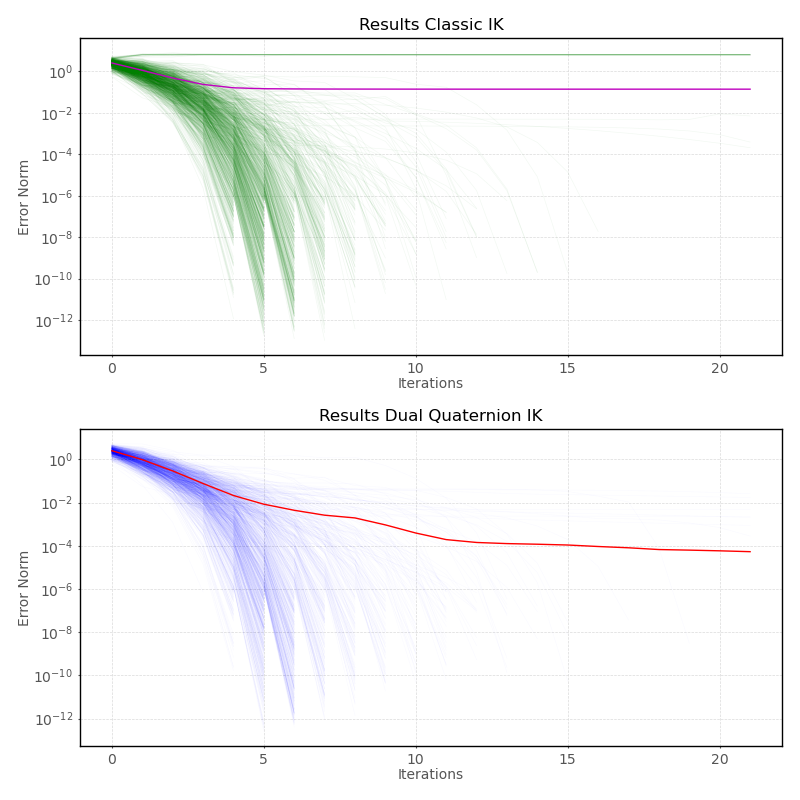

In [8]:
fk = ForwardKinematics() 
ik = InverseKinematics()

num_eval = 1000
success_count_classic = 0
success_count_DQ = 0
error_list_DQ = []
error_list_classic = []

for i in range(num_eval):
    q_guess = getRandomJointAngles()
    
    x_target = fk.getFK(perturbJointAngles(q_guess, 85))
    
    q_sol_classic, error_norm_classic, success_classic = ik.getIK_classic(x_target, q_guess, 0.01)
    q_sol_DQ, error_norm_DQ, success_DQ = ik.getIK_DQ(x_target, q_guess, 0.01)
    
    error_list_DQ.append(error_norm_DQ)
    error_list_classic.append(error_norm_classic)
    
    if success_classic:
        success_count_classic += 1
    if success_DQ:
        success_count_DQ += 1
        
plotIKResults(error_list_classic, error_list_DQ, success_count_classic, success_count_DQ, num_eval)

A big efficiency benefit is also given by the fact that the forward kinematics evaluation is roughly 30% faster than homogeneous transformation matrices in the Denavit-Hartenberg convention. The increased efficiency is mentioned in various sources, e.g. <cite id="d6d6o"><a href="#zotero%7C16222978%2FAFEHQ7QJ">(Dantam, 2021)</a></cite> and <cite id="84zhp"><a href="#zotero%7C16222978%2FZZC2ARLA">(Miranda De Farias et al., 2019)</a></cite>, and shown in <a href="./5.0_results.ipynb">Chapter 5.0</a> for a C++ implementation. Another noteworthy observation is that the dual quaternion inverse kinematic produces higher success rates for larger errors. This can be lead back to the double cover of $\mathcal{SE}(3)$, and the lack of the singularity at $\theta = \pi$ which is problematic for the error computation via matrix logarithm from the classic approach. Both approaches behave the same for small joint position errors in $\textrm{q_guess}$ (e.g. $10-20$deg).

<h1> Literature </h1>
<!-- BIBLIOGRAPHY START -->
<div class="csl-bib-body">
  <div class="csl-entry"><i id="zotero|16222978/63SGHUSV"></i>Angeles, J. (2014). <i>Fundamentals of Robotic Mechanical Systems: Theory, Methods, and Algorithms</i> (Vol. 124). Springer International Publishing. <a href="https://doi.org/10.1007/978-3-319-01851-5">https://doi.org/10.1007/978-3-319-01851-5</a></div>
  <div class="csl-entry"><i id="zotero|16222978/CX5ZL77E"></i>Beeson, P., &#38; Ames, B. (2015). TRAC-IK: An open-source library for improved solving of generic inverse kinematics. <i>2015 IEEE-RAS 15th International Conference on Humanoid Robots (Humanoids)</i>, 928–935. <a href="https://doi.org/10.1109/HUMANOIDS.2015.7363472">https://doi.org/10.1109/HUMANOIDS.2015.7363472</a></div>
  <div class="csl-entry"><i id="zotero|16222978/AFEHQ7QJ"></i>Dantam, N. T. (2021). Robust and efficient forward, differential, and inverse kinematics using dual quaternions. <i>The International Journal of Robotics Research</i>, <i>40</i>(10–11), 1087–1105. <a href="https://doi.org/10.1177/0278364920931948">https://doi.org/10.1177/0278364920931948</a></div>
  <div class="csl-entry"><i id="zotero|16222978/UIFPWU6T"></i>Lynch, K. M., &#38; Park, F. C. (2017). <i>Modern robotics: mechanics, planning, and control</i>. Cambridge University Press.</div>
  <div class="csl-entry"><i id="zotero|16222978/ZZC2ARLA"></i>Miranda De Farias, C., Da Cruz Figueredo, L. F., &#38; Yoshiyuki Ishihara, J. (2019). Performance Study on dqRNEA – A Novel Dual Quaternion Based Recursive Newton-Euler Inverse Dynamics Algorithms. <i>2019 Third IEEE International Conference on Robotic Computing (IRC)</i>, 94–101. <a href="https://doi.org/10.1109/IRC.2019.00022">https://doi.org/10.1109/IRC.2019.00022</a></div>
  <div class="csl-entry"><i id="zotero|16222978/3S984H2Z"></i>Yazdanpanah Abdolmalaki, R. (2017). <i>Geometric Jacobians Derivation and Kinematic Singularity Analysis for Smokie Robot Manipulator &#38; the Barrett WAM</i>.</div>
</div>
<!-- BIBLIOGRAPHY END -->